# Bot Detection EDA 

Course: Theoretical and Applicational Aspects of Modern Cyber(66219) <br/>
Lecturer: Dr. Uri Itai<br/>
Student: Idan Gabai 302786272<br/>

## Background

I did EDA on the bot detecion datasets in X (twitter).
<br/><a href="https://botometer.osome.iu.edu/bot-repository/datasets.html">link to repository</a> it might takse a minute for the page to load.<br/>

I took the following datasets: "botwiki-2019", "celebrity-2019", "cresci-rtbust-2019",
"cresci-stock-2018",<br/> "gilani-2017", "political-bots-2019", "pronbots-2019",
"vendor-purchased-2019", "verified-2019"

In [183]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import RidgeClassifier,SGDClassifier
from xgboost import XGBClassifier



%matplotlib inline

In [3]:
# Function to read and process each dataset
def process_dataset(name):
    merged = None
    label_file = Path(f"./data/{name}/{name}.tsv")
    data_file = Path(f"./data/{name}/{name}_tweets.json")
    
    labels = pd.read_csv(label_file, sep='\t', header=None, names=['user_id', 'label'])
    
    # print(data_file) #left for debug purpose
    with open(data_file, 'r', encoding='utf-8') as f:
        data1 = json.load(f)
        data = pd.json_normalize(data1)

        # print(data.columns)
        
        # Merge labels with data
        merged = pd.merge(data,labels, right_on='user_id', left_on='user.id', how='inner')
        merged['dataset'] = name
    
    return merged

In [4]:
datasets = [
    "botwiki-2019", "celebrity-2019", "cresci-rtbust-2019",
    "cresci-stock-2018", "gilani-2017", "political-bots-2019", "pronbots-2019",
    "vendor-purchased-2019", "verified-2019"
    ]

In [63]:
# Concatenate all datasets
all_data = pd.concat([process_dataset(name) for name in datasets], ignore_index=True)

Total number of records: 44106

Distribution of bot vs human accounts:
bot      28274
human    15832
Name: label, dtype: int64

Total Number of records per dataset:
pronbots-2019            17882
cresci-stock-2018        13276
celebrity-2019            5918
gilani-2017               2503
verified-2019             1987
vendor-purchased-2019     1087
botwiki-2019               698
cresci-rtbust-2019         693
political-bots-2019         62
Name: dataset, dtype: int64


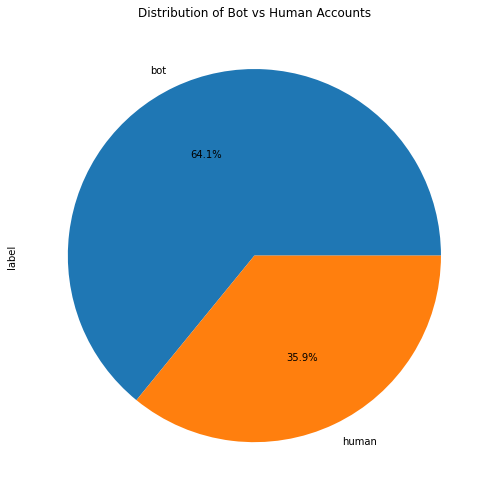

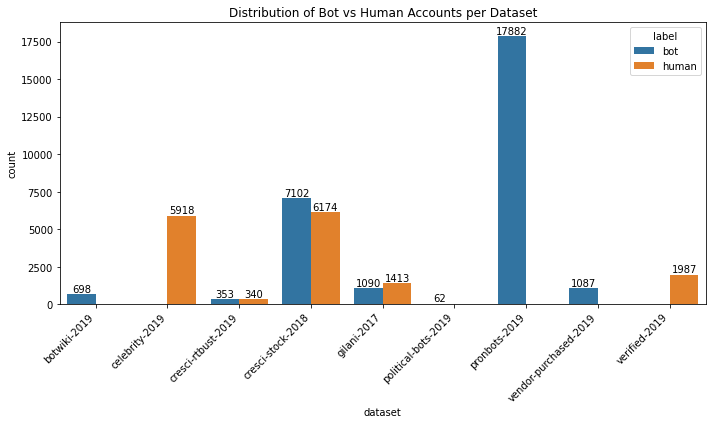

In [6]:
# Basic overview
print(f"Total number of records: {len(all_data)}")
print(f"\nDistribution of bot vs human accounts:")
print(all_data['label'].value_counts(normalize=False))

plt.figure(figsize=(10, 6))
pie_df = all_data['label'].value_counts()
plot = pie_df.plot.pie( figsize=(7, 7), autopct='%1.1f%%', startangle=0)
plt.title('Distribution of Bot vs Human Accounts')
plt.tight_layout()


print("\nTotal Number of records per dataset:")
print(all_data['dataset'].value_counts())

# Plot distribution of bot vs human accounts
plt.figure(figsize=(10, 6))
ax=sns.countplot(x='dataset', hue='label', data=all_data)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]) 
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Bot vs Human Accounts per Dataset')
plt.tight_layout()



In [62]:
all_data.shape

(43892, 48)

In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44106 entries, 0 to 44105
Data columns (total 48 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   created_at                               44106 non-null  object 
 1   user.id                                  44106 non-null  int64  
 2   user.id_str                              44106 non-null  object 
 3   user.name                                44106 non-null  object 
 4   user.screen_name                         44106 non-null  object 
 5   user.location                            44106 non-null  object 
 6   user.description                         44106 non-null  object 
 7   user.url                                 12447 non-null  object 
 8   user.entities.url.urls                   12447 non-null  object 
 9   user.entities.description.urls           44106 non-null  object 
 10  user.protected                           44106

Duplicated

In [74]:
all_data = all_data.drop_duplicates(subset=['user_id','user.name','user.screen_name'],keep='last').reset_index(drop=True)

In [75]:
all_data.duplicated(subset=['user_id','user.name','user.screen_name']).sum()

0

In [76]:
all_data.shape

(43892, 48)

### Numeric Columns EDA

In [12]:
different_id = all_data[all_data['user.id'] != all_data['user_id']]
different_id

,created_at,user.id,user.id_str,user.name,user.screen_name,user.location,user.description,user.url,user.entities.url.urls,user.entities.description.urls,...,user.default_profile,user.default_profile_image,user.following,user.follow_request_sent,user.notifications,user.translator_type,user_id,label,dataset,user.withheld_in_countries


In [13]:
numeric = all_data.select_dtypes('number').copy()
numeric.drop('user_id',axis=1,inplace=True)
numeric.drop('user.id',axis=1,inplace=True)
numeric.columns

Index(['user.followers_count', 'user.friends_count', 'user.listed_count',
       'user.favourites_count', 'user.utc_offset', 'user.statuses_count'],
      dtype='object')

In [14]:
numeric_features = [ 'user.followers_count', 'user.listed_count', 
                        'user.statuses_count', 'user.friends_count', 'user.favourites_count']

In [15]:
def plot_feature_by_account_type(df,feature, log_scale=False):
    fig, axs = plt.subplots(1,2,figsize=(10, 6))
    plt.title(f'{feature} Distribution by Account Type')
    sns.boxplot(x='label', y=feature,hue='label', data=df, ax=axs[0], log_scale=log_scale)
    sns.violinplot(x="label", y=feature, hue="label", data=df, split=True, inner="quart", ax=axs[1])
    plt.xticks(rotation=90)
    
    if log_scale:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()

user.followers_count

user.followers_count statistics by account type:
         count           mean           std  min    25%     50%       75%  \
label                                                                       
bot    28251.0   31287.446674  6.415992e+05  0.0    9.0    21.0      54.0   
human  15641.0  772516.576114  3.310260e+06  0.0  282.0  7761.0  573712.0   

               max  
label               
bot     42709246.0  
human  106938028.0  


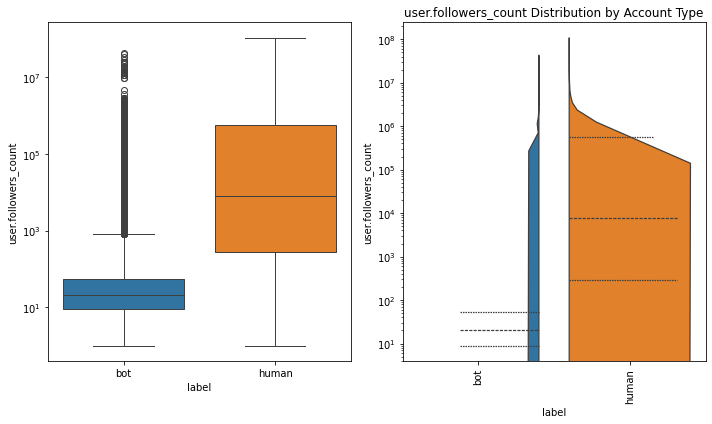

user.friends_count

user.friends_count statistics by account type:
         count         mean           std  min    25%    50%     75%  \
label                                                                  
bot    28251.0  3350.009062  48874.661473  0.0    0.0    0.0    76.0   
human  15641.0  6492.292053  55523.633992  0.0  118.0  422.0  1060.0   

             max  
label             
bot    4249178.0  
human  1862485.0  


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


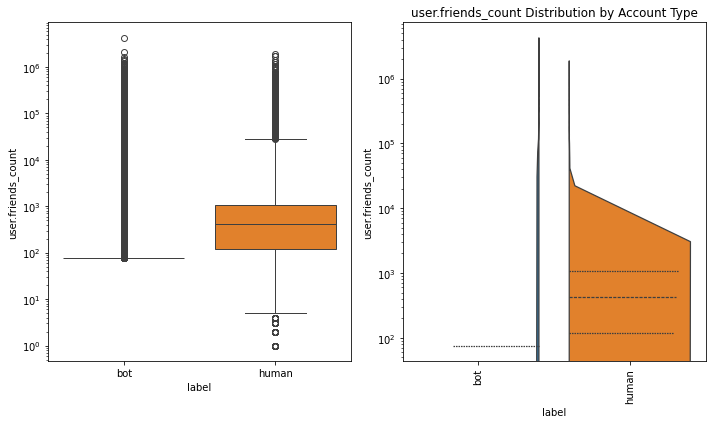

user.listed_count

user.listed_count statistics by account type:
         count         mean           std  min  25%    50%     75%        max
label                                                                        
bot    28251.0   110.854695   2334.861734  0.0  0.0    0.0     0.0   198862.0
human  15641.0  2105.285851  27181.041614  0.0  2.0  117.0  1248.0  3233474.0


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


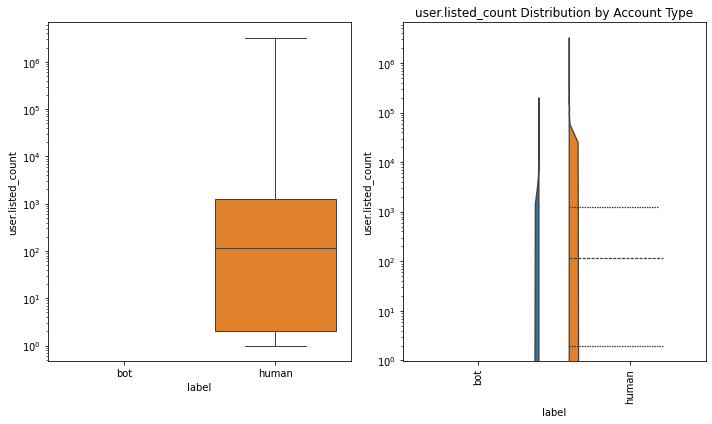

user.favourites_count

user.favourites_count statistics by account type:
         count         mean           std  min    25%     50%     75%  \
label                                                                   
bot    28251.0  1718.627164  13208.007160  0.0  129.0   272.0   930.5   
human  15641.0  9361.294099  24029.834377  0.0  218.0  1740.0  7949.0   

            max  
label            
bot    886115.0  
human  572806.0  


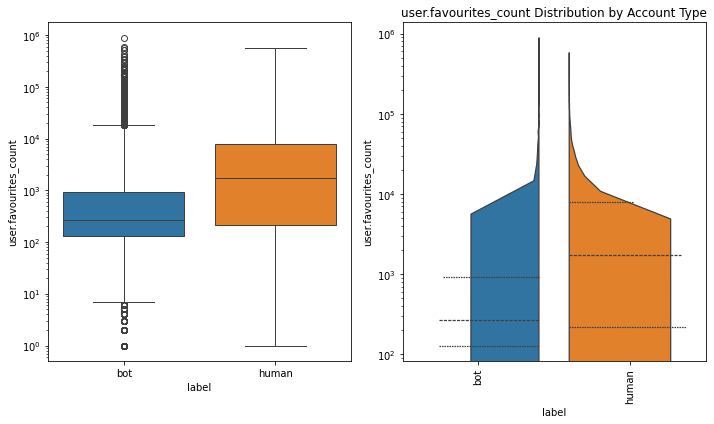

user.utc_offset

user.utc_offset statistics by account type:
        count         mean           std      min      25%      50%     75%  \
label                                                                         
bot    2804.0 -5207.417974  20635.435387 -39600.0 -25200.0 -10800.0  7200.0   
human  5111.0 -7981.843084  17797.260476 -39600.0 -21600.0 -14400.0  7200.0   

           max  
label           
bot    46800.0  
human  46800.0  


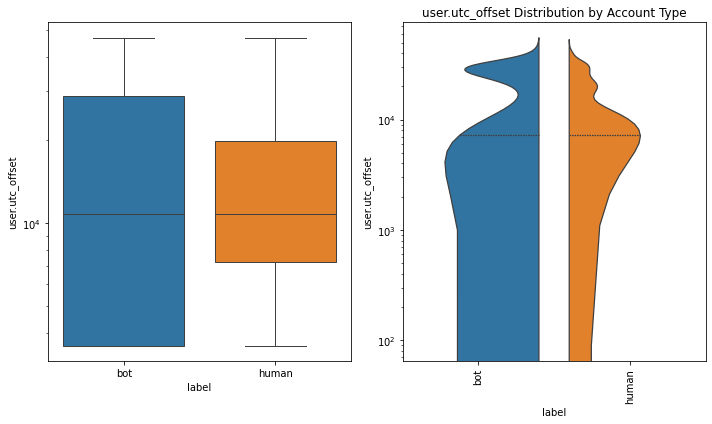

user.statuses_count

user.statuses_count statistics by account type:
         count          mean           std  min     25%     50%      75%  \
label                                                                      
bot    28251.0   8212.539945  59897.321898  1.0    33.0    88.0   1745.5   
human  15641.0  20915.087654  46268.034098  1.0  2107.0  7544.0  22375.0   

             max  
label             
bot    2766520.0  
human  1710193.0  


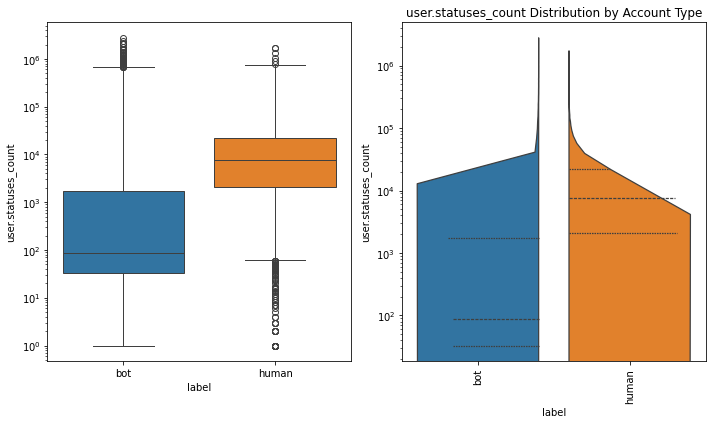

In [16]:
for num_feature in numeric.columns:
    print(num_feature)
    print(f"\n{num_feature} statistics by account type:")
    print(all_data.groupby('label')[num_feature].describe())
    plot_feature_by_account_type(all_data, num_feature,True)

In [17]:
# plt.figure(figsize=(10, 6))
# sns.histplot(x='user.followers_count', hue='label',data=all_data, kde=True)
# plt.title(f'Distribution of user.followers_coun')
# plt.tight_layout()
# # plt.savefig(f'{feature.replace(".", "_")}_distribution.png')
# # plt.close()
# plt.show()

### Categorical data

#### Boolean Data

we have 14 columns of bool data, let's have a look on the 7 more interesting columns<br>
* user.geo_enabled
* user.verified
* user.profile_background_tile
* user.profile_use_background_image
* user.has_extended_profile
* user.default_profile
* user.default_profile_image

In [18]:
bool_cols = [
"user.geo_enabled",
"user.verified",
"user.profile_background_tile",
"user.profile_use_background_image",
"user.has_extended_profile",
"user.default_profile",
"user.default_profile_image"
]

In [19]:
def crosstab(f1,f2,df):
    print(f"crosstab f1:{f1}, f2:{f2}")
    res = pd.crosstab(df[f1],df[f2])
    print(res)
    return res

In [20]:
f2=  'label'
for b_col in bool_cols:
    crosstab(b_col,f2,all_data)

crosstab f1:user.geo_enabled, f2:label
label               bot  human
user.geo_enabled              
False             24659   7130
True               3592   8511
crosstab f1:user.verified, f2:label
label            bot  human
user.verified              
False          27932   8863
True             319   6778
crosstab f1:user.profile_background_tile, f2:label
label                           bot  human
user.profile_background_tile              
False                         25616  10874
True                           2635   4767
crosstab f1:user.profile_use_background_image, f2:label
label                                bot  human
user.profile_use_background_image              
False                               1467   2376
True                               26784  13265
crosstab f1:user.has_extended_profile, f2:label
label                        bot  human
user.has_extended_profile              
False                      25494  10200
True                        2757   5441
crosstab f

#### Multi-class categorical data

In [21]:
cat_data = all_data.select_dtypes('object').copy()
cat_data.drop(columns=['user.id_str','dataset'], axis=1)
cat_data.columns

Index(['created_at', 'user.id_str', 'user.name', 'user.screen_name',
       'user.location', 'user.description', 'user.url',
       'user.entities.url.urls', 'user.entities.description.urls',
       'user.created_at', 'user.time_zone', 'user.lang',
       'user.profile_background_color', 'user.profile_background_image_url',
       'user.profile_background_image_url_https', 'user.profile_image_url',
       'user.profile_image_url_https', 'user.profile_banner_url',
       'user.profile_link_color', 'user.profile_sidebar_border_color',
       'user.profile_sidebar_fill_color', 'user.profile_text_color',
       'user.translator_type', 'label', 'dataset',
       'user.withheld_in_countries'],
      dtype='object')

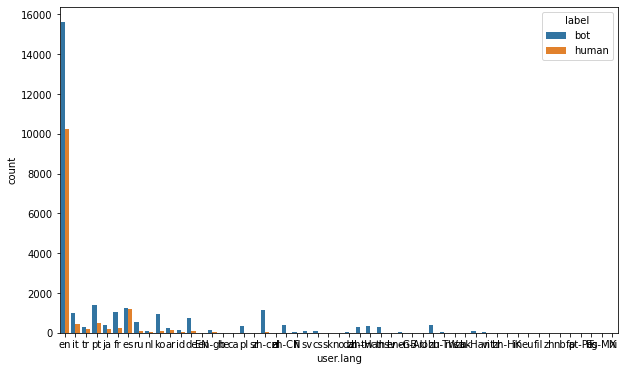

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='user.lang',hue='label',data=cat_data)
plt.show()

In [23]:
def apply_name(name):
    if "$$" in name:
        name = name.replace("$$",'ss')
    return name

# plt.figure(figsize=(10, 6))
# f1 = 'user.location'
# cat_data[f1] = cat_data[f1].apply(apply_name)
# sns.countplot(x=f1,hue='label',data=cat_data)
# plt.show()

In [96]:
def categorical_eda(df, max_categories=15,min_count=1000):
    # Get categorical columns with less than max_categories unique values
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # cat_columns = [col for col in cat_columns if df[col].nunique() < max_categories]
    
    res = []
    for col in cat_columns:
        # print(f"curr col:{col}")
        value_counts = df[col].value_counts()
        unique_count = len(value_counts)
        if unique_count < max_categories:
            res.append(col)
        else:
            # print(f"column-{col}:# unique values:{df[col].nunique()}")
            # high_freq_categories = value_counts[value_counts >= min_count]
            # if len(high_freq_categories) > 0:
            #     # Group low frequency categories into 'Other'
            #         df[f'{col}_grouped'] = df[col].apply(lambda x: x if x in high_freq_categories.index else 'Other')
                    
            #         plt.figure(figsize=(10, 6))
            #         sns.countplot(y=f'{col}_grouped', data=df, order=df[f'{col}_grouped'].value_counts().index, hue='label')
            #         plt.title(f'Distribution of {col} (Grouped)')
            #         plt.xlabel('Count')
            #         plt.ylabel(col)
            #         plt.tight_layout()
            #         plt.show()
                    
            #         print(f"\nGrouped value counts for {col}:")
            #         grouped_counts = df[f'{col}_grouped'].value_counts()
            #         grouped_percentage = df[f'{col}_grouped'].value_counts(normalize=True) * 100
            #         for value, count in grouped_counts.items():
            #             percentage = grouped_percentage[value]
            #             print(f"{value}: {count} ({percentage:.2f}%)")
                    
            #         # Remove the temporary grouped column
            #         df.drop(f'{col}_grouped', axis=1, inplace=True)
            # else:
                print(f"\n{col} has {unique_count} unique values, all with counts less than {min_count}.")
    cat_columns = res
    print(f"columns wiht {max_categories} or less are :{res}")
    for col in cat_columns:
        plt.figure(figsize=(10, 6))
        
        # Create a count plot
        sns.countplot(y=col, data=df, order=df[col].value_counts().index, hue="label")
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
        
        # Print value counts and percentage
        value_counts = df[col].value_counts()
        value_percentage = df[col].value_counts(normalize=True) * 100
        print(f"\nValue counts for {col}:")
        for value, count in value_counts.items():
            percentage = value_percentage[value]
            print(f"{value}: {count} ({percentage:.2f}%)")
        
        print("\n" + "="*50 + "\n")


created_at has 42148 unique values, all with counts less than 1000.

user.id_str has 43879 unique values, all with counts less than 1000.

user.name has 40698 unique values, all with counts less than 1000.

user.screen_name has 43879 unique values, all with counts less than 1000.

user.location has 10652 unique values, all with counts less than 1000.

user.description has 37729 unique values, all with counts less than 1000.

user.url has 12151 unique values, all with counts less than 1000.

user.created_at has 43872 unique values, all with counts less than 1000.

user.time_zone has 155 unique values, all with counts less than 1000.

user.lang has 53 unique values, all with counts less than 1000.

user.profile_background_color has 2687 unique values, all with counts less than 1000.

user.profile_background_image_url has 4975 unique values, all with counts less than 1000.

user.profile_background_image_url_https has 4975 unique values, all with counts less than 1000.

user.profile_image

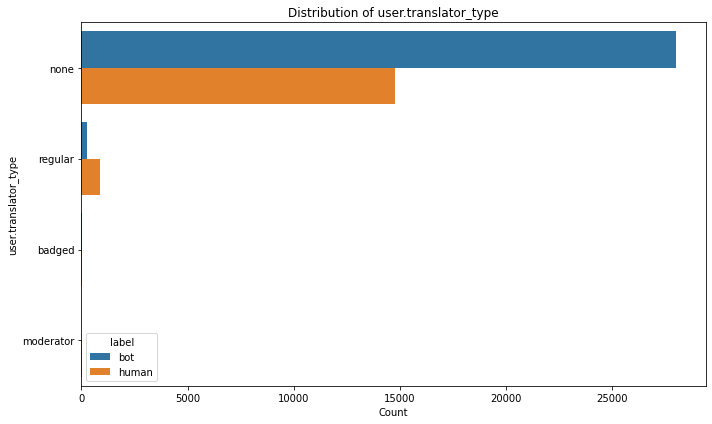


Value counts for user.translator_type:
none: 42767 (97.44%)
regular: 1116 (2.54%)
badged: 7 (0.02%)
moderator: 2 (0.00%)




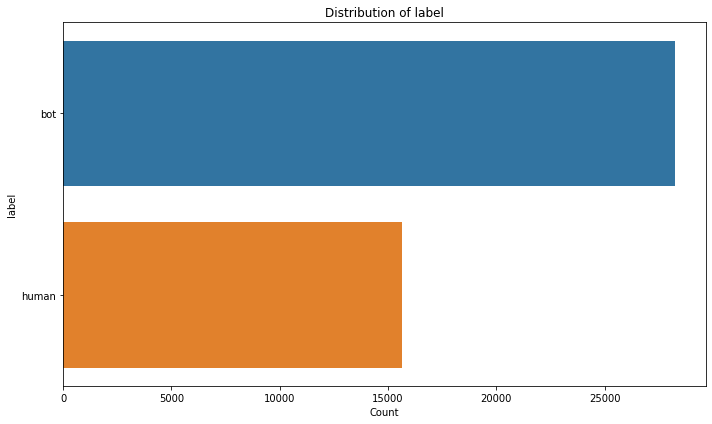


Value counts for label:
bot: 28251 (64.36%)
human: 15641 (35.64%)




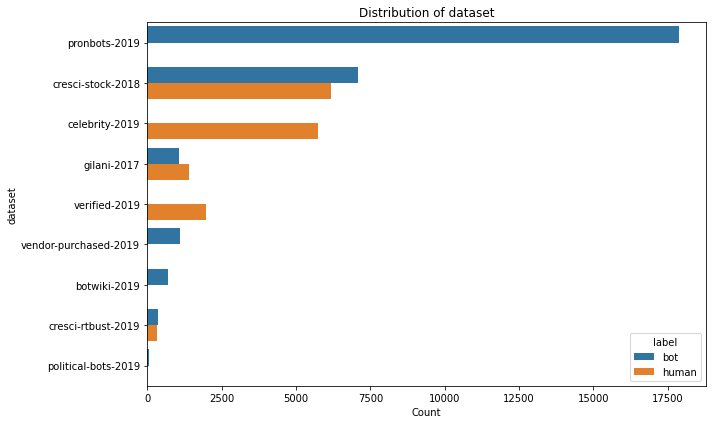


Value counts for dataset:
pronbots-2019: 17882 (40.74%)
cresci-stock-2018: 13273 (30.24%)
celebrity-2019: 5732 (13.06%)
gilani-2017: 2478 (5.65%)
verified-2019: 1987 (4.53%)
vendor-purchased-2019: 1087 (2.48%)
botwiki-2019: 698 (1.59%)
cresci-rtbust-2019: 693 (1.58%)
political-bots-2019: 62 (0.14%)




In [61]:
cat_data2 = cat_data.drop(columns=['user.entities.url.urls','user.entities.description.urls','user.withheld_in_countries'])
categorical_eda(cat_data2)

check if bots creators love emojis

In [51]:
import re

def contains_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(str(text)))

cat_data['contains_emoji'] = cat_data['user.name'].apply(contains_emoji)

crosstab('contains_emoji','label',cat_data)

crosstab f1:contains_emoji, f2:label
label             bot  human
contains_emoji              
False           27386  14326
True              865   1315


label,bot,human
contains_emoji,,
False,27386,14326
True,865,1315


nothing too significant in the dataset

### datetime data

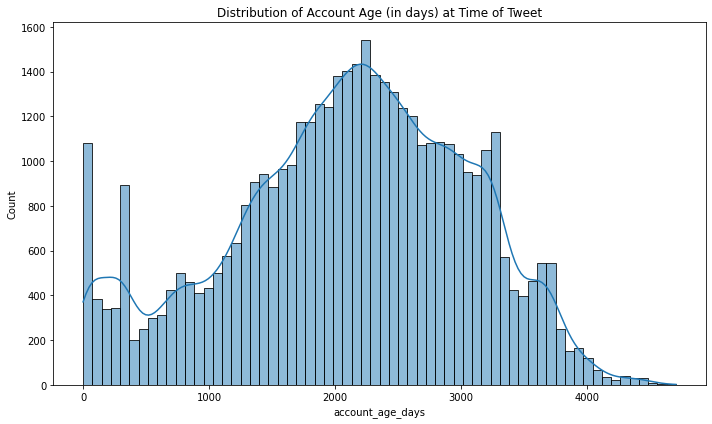

In [95]:
# Analyze dates

all_data['created_at'] = pd.to_datetime(all_data['created_at'])
all_data['user.created_at'] = pd.to_datetime(all_data['user.created_at'])



# Account age at time of tweet
all_data['account_age_days'] = (all_data['created_at'] - all_data['user.created_at']).dt.days

plt.figure(figsize=(10, 6))
ax = sns.histplot(all_data['account_age_days'], kde=True)
# ax.bar_label(ax.containers[0])
plt.title('Distribution of Account Age (in days) at Time of Tweet')
plt.tight_layout()
plt.show()

### Preprocessing

cleaning the data from missing values and outliers

In [134]:
df = all_data.drop(columns=['user.url','user.entities.url.urls','user.utc_offset','user.time_zone','user.lang',
                            'user.profile_background_image_url','user.profile_background_image_url_https',
                            'user.profile_banner_url','user.entities.description.urls','user.withheld_in_countries'],axis=1)

In [135]:
df = df.drop(columns=['dataset','user_id','user.id'],axis=1)

In [136]:
df = df.drop(columns=['user.protected', 'user.contributors_enabled', 'user.is_translator',
       'user.is_translation_enabled', 'user.following', 'user.follow_request_sent', 'user.notifications'],axis=1)

In [137]:
df = df.drop(columns=['created_at','user.created_at'],axis=1)

In [138]:
def map_bool(x):
    if x == 'bot':
        return 1
    else:
        return 0
    # return 1 if 'bot' else 0
df['label'] = df['label'].apply(map_bool)

In [110]:
df.columns

Index(['user.id_str', 'user.name', 'user.screen_name', 'user.location',
       'user.description', 'user.followers_count', 'user.friends_count',
       'user.listed_count', 'user.favourites_count', 'user.geo_enabled',
       'user.verified', 'user.statuses_count', 'user.profile_background_color',
       'user.profile_background_tile', 'user.profile_image_url',
       'user.profile_image_url_https', 'user.profile_link_color',
       'user.profile_sidebar_border_color', 'user.profile_sidebar_fill_color',
       'user.profile_text_color', 'user.profile_use_background_image',
       'user.has_extended_profile', 'user.default_profile',
       'user.default_profile_image', 'user.translator_type', 'label',
       'account_age_days'],
      dtype='object')

#### Split Data

In [140]:
y = df['label']
x = df.drop(columns=['label'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

In [165]:
def plot_classification_metrics(y_true, y_pred):
    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    # Prepare data for plotting
    metrics = ['Precision', 'Accuracy', 'F1-macro']
    scores = [precision, accuracy, f1]

    # Create bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

    # Customize the plot
    ax.set_ylim(0, 1)
    ax.set_title('Classification Metrics Comparison', fontsize=16)
    ax.set_ylabel('Score', fontsize=12)
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    # Add a horizontal line at y=0.5 for reference
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)

    # Improve layout
    plt.tight_layout()

    # Show plot
    plt.show()

    conf_mat = confusion_matrix(y_true,y_pred)
    cm_display  = ConfusionMatrixDisplay(conf_mat)
    fig, ax = plt.subplots(figsize=(10, 8))
    cm_display.plot(ax=ax, cmap='Blues', values_format='d')

    # Improve the display
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()




##### run basic classifires

In [179]:
def get_transformer(x_train,is_le=False):
    categorical = x_train.dtypes == object

    preprocess = make_column_transformer(
        (StandardScaler(), ~categorical),
        (OneHotEncoder(handle_unknown="infrequent_if_exist",drop='first'), categorical))
    if is_le:
        preprocess = make_column_transformer(
        (StandardScaler(), ~categorical),
        (LabelEncoder(), categorical))
    return preprocess

In [184]:
def grid_search_model(model,param_grid,x_train, y_train,x_test,y_test,is_le=False):
    
    preprocess = get_transformer(x_train,is_le)
    
    # Define the model PL
    clf_PL = make_pipeline(preprocess, model)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=clf_PL, param_grid=param_grid, 
                            cv=5, scoring=f1_score, n_jobs=-1)

    # Fit the GridSearchCV object to the data
    grid_search.fit(x_train, y_train)

    # Print the best parameters and score
    print("Best parameters:", grid_search.best_params_)

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(x_test)

    plot_classification_metrics(y_test,predictions)
    return best_model,predictions

c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Best parameters: {'verbose': False}


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


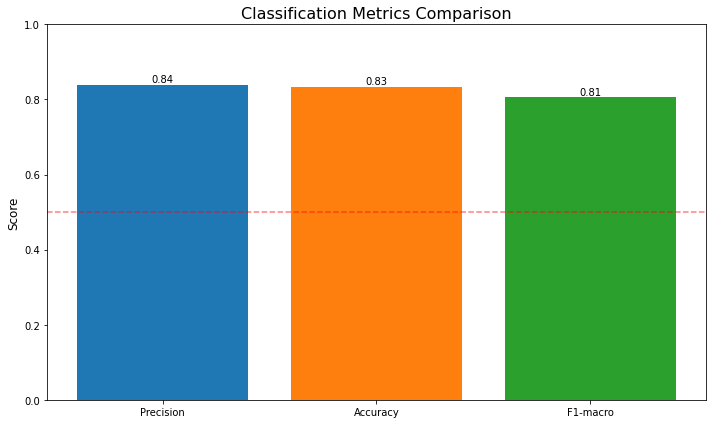

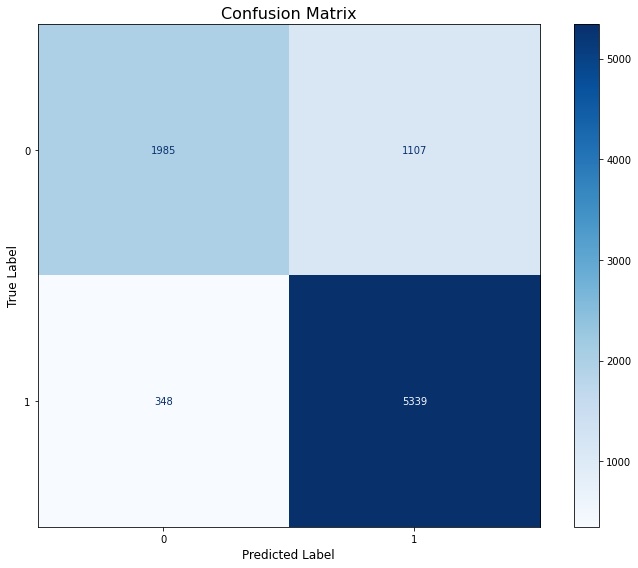

In [185]:
model = RidgeClassifier()


param_grid = {

    'verbose': [False]  # Constraint the coefficients to be positive
}
best_model,preds = grid_search_model(model,param_grid,x_train, y_train,x_test,y_test)

c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Best parameters: {'sgdclassifier__alpha': 0.0001}


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


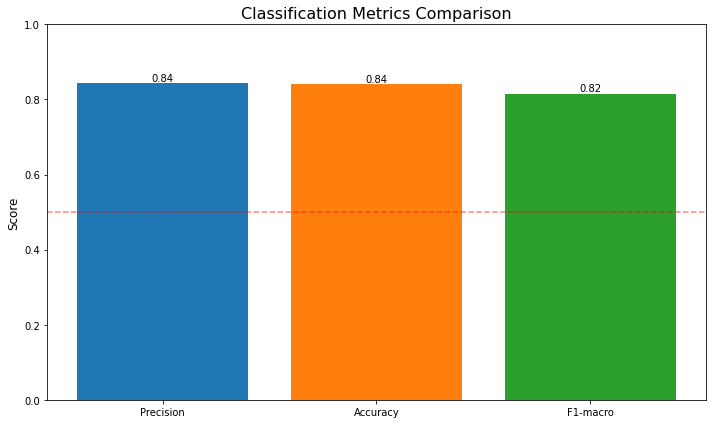

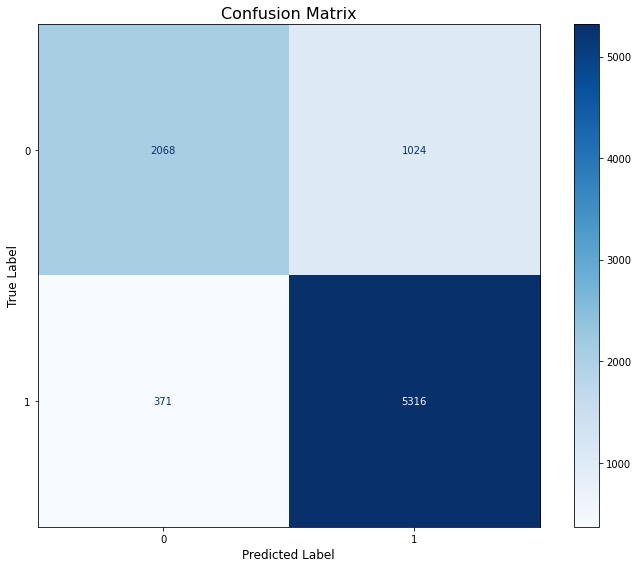

In [191]:
param_grid = {
    # 'sgdclassifier__loss': ['hinge', 'log_loss', 'modified_huber'],
    # 'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01],
    # 'sgd__max_iter': [1000, 2000],
    # 'sgdclassifier__learning_rate': ['constant', 'optimal', 'adaptive'],
    # 'sgd__eta0': [0.01, 0.1]
}


model = SGDClassifier(random_state=42)

best_model,preds = grid_search_model(model,param_grid,x_train, y_train,x_test,y_test)

c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Best parameters: {'xgbclassifier__learning_rate': 0.01}


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


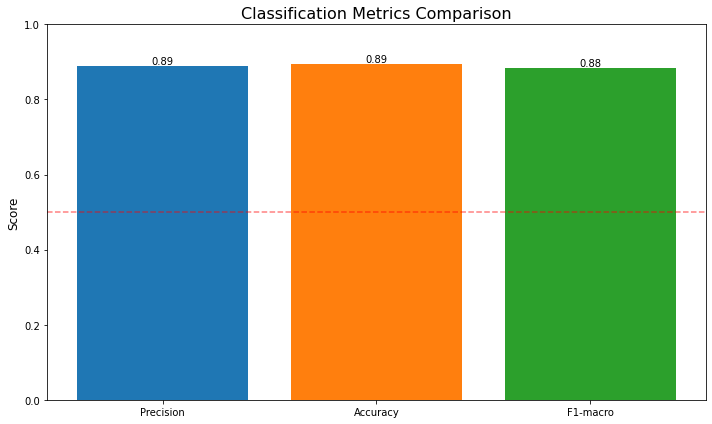

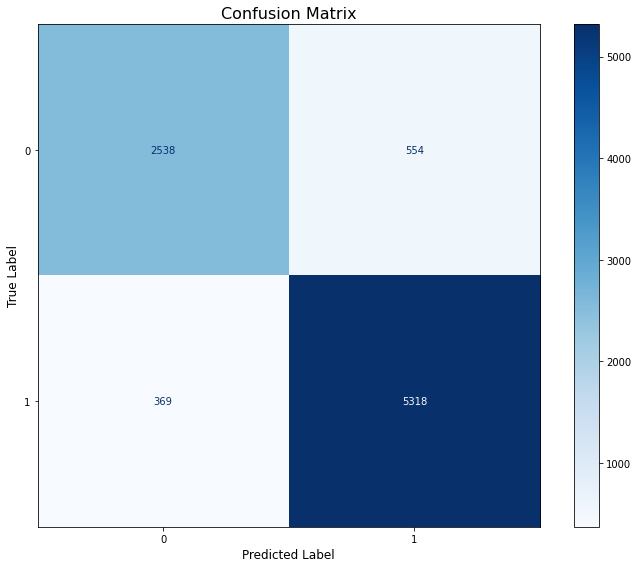

In [192]:
# Initialize the XGBoost classifier
param_grid = {
    # 'max_depth': [3, 4, 5],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
    # 'n_estimators': [100, 200],
    # 'min_child_weight': [1, 3, 5],
    # 'subsample': [0.8, 1.0],
    # 'colsample_bytree': [0.8, 1.0]
}


model = XGBClassifier(random_state=42)

# Set up GridSearchCV
best_model,preds = grid_search_model(model,param_grid,x_train, y_train,x_test,y_test)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset
# df = pd.read_csv("path_to_your_cresci-stock-2018_dataset.csv")  # Replace with your actual file path
df = all_data

# Basic info
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

# Function to plot categorical features
def plot_categorical(feature):
    plt.figure(figsize=(10, 6))
    df[feature].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig(f'{feature.replace(".", "_")}_distribution.png')
    # plt.close()
    plt.show()

# Function to plot numeric features
def plot_numeric(feature):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    # plt.savefig(f'{feature.replace(".", "_")}_distribution.png')
    # plt.close()
    plt.show()

def do_EDA(df,dataset_name=""):

    # Analyze categorical features
    categorical_features = ['user.follow_request_sent', 'user.has_extended_profile', 
                            'user.profile_use_background_image', 'user.default_profile_image', 
                            'user.verified', 'user.translator_type', 'user.is_translation_enabled', 
                            'user.geo_enabled', 'user.lang', 'user.profile_background_tile', 
                            'user.protected', 'user.default_profile', 'user.is_translator', 'label']

    for feature in categorical_features:
        print(f"\n{feature} value counts:")
        print(df[feature].value_counts(normalize=True))
        plot_categorical(feature)

    # Analyze numeric features
    # 'user.id',
    numeric_features = [ 'user.followers_count', 'user.listed_count', 
                        'user.statuses_count', 'user.friends_count', 'user.favourites_count']

    # for feature in numeric_features:
    #     print(f"\n{feature} statistics:")
    #     print(df[feature].describe())
    #     plot_numeric(feature)

    # Analyze dates
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['user.created_at'] = pd.to_datetime(df['user.created_at'])

    print("\nDate range of tweets:")
    print(f"Earliest: {df['created_at'].min()}")
    print(f"Latest: {df['created_at'].max()}")

    print("\nDate range of account creation:")
    print(f"Earliest: {df['user.created_at'].min()}")
    print(f"Latest: {df['user.created_at'].max()}")

    # Account age at time of tweet
    df['account_age_days'] = (df['created_at'] - df['user.created_at']).dt.days

    plt.figure(figsize=(10, 6))
    sns.histplot(df['account_age_days'], kde=True)
    plt.title('Distribution of Account Age (in days) at Time of Tweet')
    plt.tight_layout()
    # plt.savefig('account_age_distribution.png')
    # plt.close()
    plt.show()

    # Analyze text-based features
    text_features = ['user.description', 'user.name', 'user.screen_name']

    for feature in text_features:
        df[f'{feature}_length'] = df[feature].str.len()
        print(f"\n{feature} length statistics:")
        print(df[f'{feature}_length'].describe())
        plot_numeric(f'{feature}_length')

    # Correlation analysis
    correlation_features = numeric_features + [f'{feature}_length' for feature in text_features]
    correlation_matrix = df[correlation_features].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    # plt.savefig('correlation_matrix.png')
    # plt.close()
    plt.show()

    # Analyze relationship between numeric features and bot/human classification
    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(numeric_features, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x='label', y=feature, data=df)
        plt.title(f'{feature} by Account Type')
        plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('numeric_features_by_account_type.png')
    # plt.close()
    plt.show()

    print("\nEDA completed. Check the generated PNG files for visualizations.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43892 entries, 0 to 43891
Data columns (total 48 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   created_at                               43892 non-null  object 
 1   user.id                                  43892 non-null  int64  
 2   user.id_str                              43892 non-null  object 
 3   user.name                                43892 non-null  object 
 4   user.screen_name                         43892 non-null  object 
 5   user.location                            43892 non-null  object 
 6   user.description                         43892 non-null  object 
 7   user.url                                 12265 non-null  object 
 8   user.entities.url.urls                   12265 non-null  object 
 9   user.entities.description.urls           43892 non-null  object 
 10  user.protected                           43892

## EDA cresci-stock-2018

In [ ]:
# List of all datasets
datasets = [
    "cresci-stock-2018"
    #,"vendor-purchased-2019"
    # , "verified-2019"
]

# Concatenate all datasets
# all_data = pd.concat([ for name in datasets], ignore_index=True)

for name in datasets:
    df = process_dataset(name)
    # do_EDA(df)



In [ ]:
# Function to plot feature distribution by account type
def plot_feature_by_account_type(feature, log_scale=False):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(f'{feature} Distribution by Account Type')
    if log_scale:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


def do_EDA2(df,dataset_name=""):
    
    # Ensure 'label' column exists and contains 'bot' and 'human' labels
    if 'label' not in df.columns:
        print("Error: 'label' column not found in the dataset.")
        exit()

    # Basic info
    print(df['label'].value_counts(normalize=True))
    print("\nMissing values in label column:", df['label'].isnull().sum())

    # Analyze numeric features
    numeric_features = ['user.followers_count', 'user.friends_count', 'user.listed_count', 
                        'user.statuses_count', 'user.favourites_count']

    for feature in numeric_features:
        print(f"\n{feature} statistics by account type:")
        print(df.groupby('label')[feature].describe())
        plot_feature_by_account_type(feature, log_scale=True)

    # Analyze categorical features
    categorical_features = ['user.verified', 'user.geo_enabled', 'user.default_profile', 
                            'user.default_profile_image', 'user.has_extended_profile']

    for feature in categorical_features:
        print(f"\n{feature} distribution by account type:")
        print(df.groupby('label')[feature].value_counts(normalize=True))
        plt.figure(figsize=(10, 6))
        sns.countplot(x=feature, hue='label', data=df)
        plt.title(f'{feature} Distribution by Account Type')
        plt.tight_layout()
        plt.show()


        # Analyze dates
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['user.created_at'] = pd.to_datetime(df['user.created_at'])

    print("\nDate range of tweets:")
    print(f"Earliest: {df['created_at'].min()}")
    print(f"Latest: {df['created_at'].max()}")

    print("\nDate range of account creation:")
    print(f"Earliest: {df['user.created_at'].min()}")
    print(f"Latest: {df['user.created_at'].max()}")

    # Account age at time of tweet
    df['account_age_days'] = (df['created_at'] - df['user.created_at']).dt.days


    # # Analyze account age
    # df['user.created_at'] = pd.to_datetime(df['user.created_at'])
    # df['account_age_days'] = (pd.Timestamp.now() - df['user.created_at']).dt.days

    

    print("\nAccount age statistics by account type:")
    print(df.groupby('label')['account_age_days'].describe())
    plot_feature_by_account_type('account_age_days', log_scale=True)

    # Analyze text-based features
    text_features = ['user.description', 'user.name', 'user.screen_name']

    for feature in text_features:
        df[f'{feature}_length'] = df[feature].str.len()
        print(f"\n{feature} length statistics by account type:")
        print(df.groupby('label')[f'{feature}_length'].describe())
        plot_feature_by_account_type(f'{feature}_length', log_scale=True)

    # Correlation analysis
    correlation_features = numeric_features + [f'{feature}_length' for feature in text_features] + ['account_age_days']
    correlation_matrix = df[correlation_features + ['label']].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Features with Label')
    plt.tight_layout()
    plt.show()

    # Feature importance using mutual information
    X = df[correlation_features]
    y = df['label']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    mi_scores = mutual_info_classif(X, y_encoded)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    mi_scores.plot.bar()
    plt.title('Feature Importance (Mutual Information)')
    plt.tight_layout()
    plt.show()

    print("\nTop 5 most important features:")
    print(mi_scores.head())

    print("\nEDA completed. All plots have been displayed interactively.")

In [ ]:
# List of all datasets
datasets = [
    # "cresci-stock-2018"
    "vendor-purchased-2019"
    # , "verified-2019"
]

# Concatenate all datasets
# all_data = pd.concat([ for name in datasets], ignore_index=True)

for name in datasets:
    df = process_dataset(name)
    # do_EDA2(df)

In [ ]:
# List of all datasets
datasets = [
    "cresci-stock-2018"
    #,"vendor-purchased-2019"
    # , "verified-2019"
]

# Concatenate all datasets
# all_data = pd.concat([ for name in datasets], ignore_index=True)

for name in datasets:
    df = process_dataset(name)
    # do_EDA2(df)

# EDA for all data

### Examing the data

In [ ]:
all_data.head(2)

,created_at,user.id,user.id_str,user.name,user.screen_name,user.location,user.description,user.url,user.entities.url.urls,user.entities.description.urls,...,user.default_profile,user.default_profile_image,user.following,user.follow_request_sent,user.notifications,user.translator_type,user_id,label,dataset,user.withheld_in_countries
0,Wed Jun 05 21:43:20 +0000 2019,969398693249126400,969398693249126400,Random Goth Lyric Generator,goth_lyrics,City of Dis,Esoteric dark verse from aeons before twitter ...,https://t.co/s9UkVMDACm,"[{'url': 'https://t.co/s9UkVMDACm', 'expanded_...",[],...,False,False,False,False,False,none,969398693249126400,bot,botwiki-2019,NaN
1,Tue Apr 02 13:26:02 +0000 2019,2402022649,2402022649,Transiting Now,transitingnow,Earth,Demonstrating the vast number of transiting ex...,https://t.co/L8ARV5JWBz,"[{'url': 'https://t.co/L8ARV5JWBz', 'expanded_...",[],...,False,False,False,False,False,none,2402022649,bot,botwiki-2019,NaN


In [ ]:
all_data.dtypes

created_at                                  object
user.id                                      int64
user.id_str                                 object
user.name                                   object
user.screen_name                            object
user.location                               object
user.description                            object
user.url                                    object
user.entities.url.urls                      object
user.entities.description.urls              object
user.protected                                bool
user.followers_count                         int64
user.friends_count                           int64
user.listed_count                            int64
user.created_at                             object
user.favourites_count                        int64
user.utc_offset                            float64
user.time_zone                              object
user.geo_enabled                              bool
user.verified                  

### Dropping the irrelevant data

dropping the following data:
user.id_str
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_image_url
user.profile_image_url_https
user.profile_banner_url

In [ ]:
drop_cols =[
    "user.id_str",
    "user.profile_background_image_url",
    "user.profile_background_image_url_https",
    "user.profile_image_url",
    "user.profile_image_url_https",
    "user.profile_banner_url"
]


df = all_data.drop(drop_cols, axis=1)

bot      0.643648
human    0.356352
Name: label, dtype: float64

Missing values in label column: 0

user.followers_count statistics by account type:
         count           mean           std  min    25%     50%       75%  \
label                                                                       
bot    28251.0   31287.446674  6.415992e+05  0.0    9.0    21.0      54.0   
human  15641.0  772516.576114  3.310260e+06  0.0  282.0  7761.0  573712.0   

               max  
label               
bot     42709246.0  
human  106938028.0  


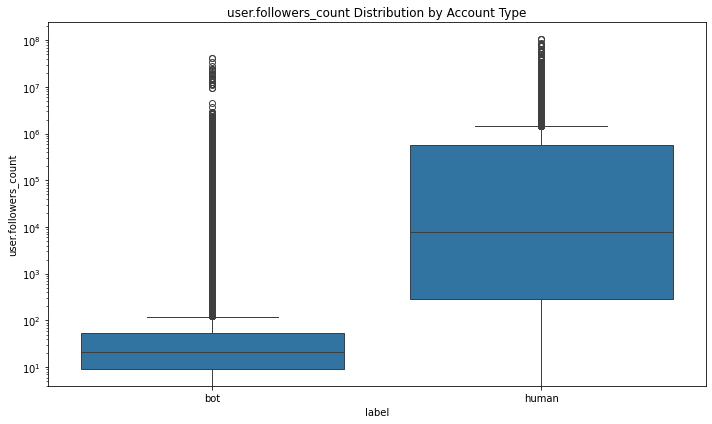


user.friends_count statistics by account type:
         count         mean           std  min    25%    50%     75%  \
label                                                                  
bot    28251.0  3350.009062  48874.661473  0.0    0.0    0.0    76.0   
human  15641.0  6492.292053  55523.633992  0.0  118.0  422.0  1060.0   

             max  
label             
bot    4249178.0  
human  1862485.0  


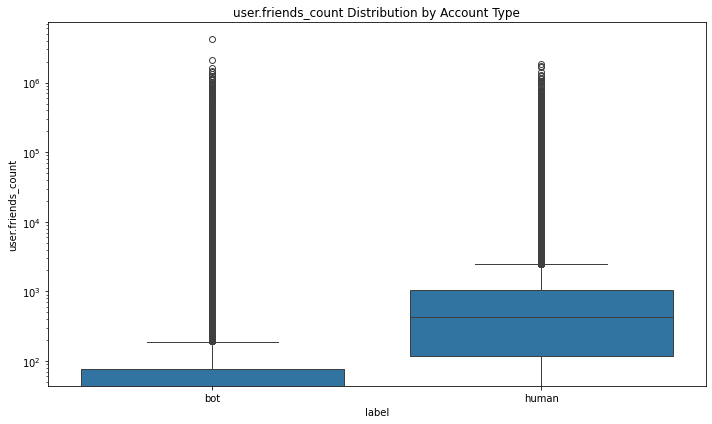


user.listed_count statistics by account type:
         count         mean           std  min  25%    50%     75%        max
label                                                                        
bot    28251.0   110.854695   2334.861734  0.0  0.0    0.0     0.0   198862.0
human  15641.0  2105.285851  27181.041614  0.0  2.0  117.0  1248.0  3233474.0


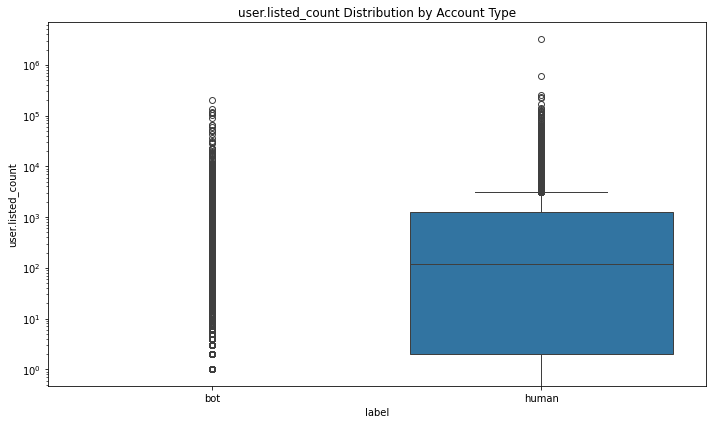


user.statuses_count statistics by account type:
         count          mean           std  min     25%     50%      75%  \
label                                                                      
bot    28251.0   8212.539945  59897.321898  1.0    33.0    88.0   1745.5   
human  15641.0  20915.087654  46268.034098  1.0  2107.0  7544.0  22375.0   

             max  
label             
bot    2766520.0  
human  1710193.0  


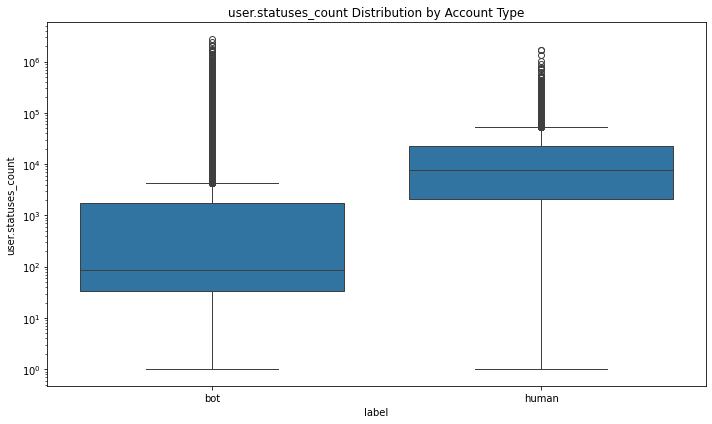


user.favourites_count statistics by account type:
         count         mean           std  min    25%     50%     75%  \
label                                                                   
bot    28251.0  1718.627164  13208.007160  0.0  129.0   272.0   930.5   
human  15641.0  9361.294099  24029.834377  0.0  218.0  1740.0  7949.0   

            max  
label            
bot    886115.0  
human  572806.0  


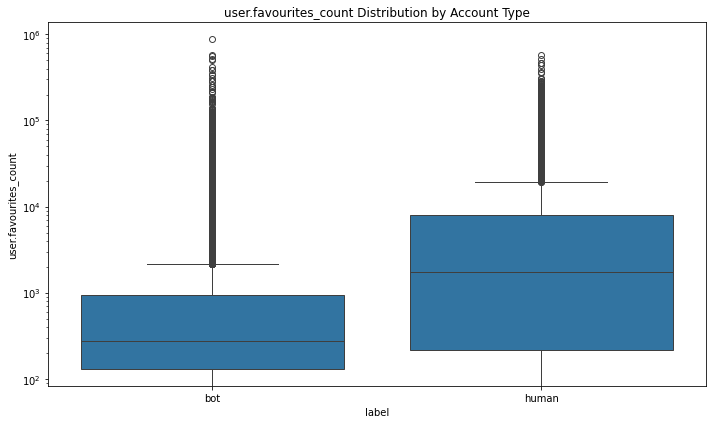


user.verified distribution by account type:
label  user.verified
bot    False            0.988708
       True             0.011292
human  False            0.566652
       True             0.433348
Name: user.verified, dtype: float64


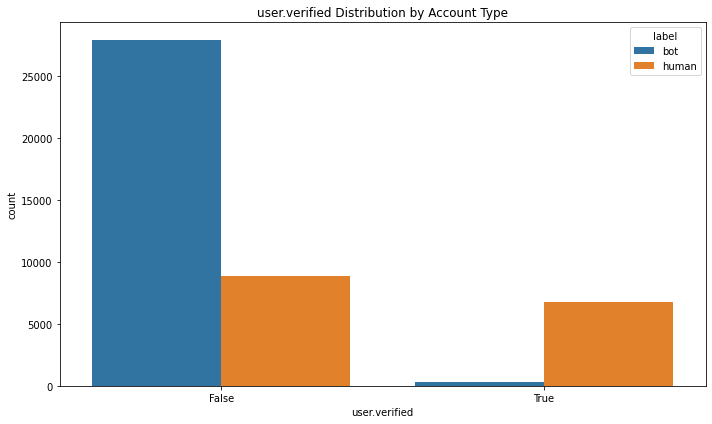


user.geo_enabled distribution by account type:
label  user.geo_enabled
bot    False               0.872854
       True                0.127146
human  True                0.544147
       False               0.455853
Name: user.geo_enabled, dtype: float64


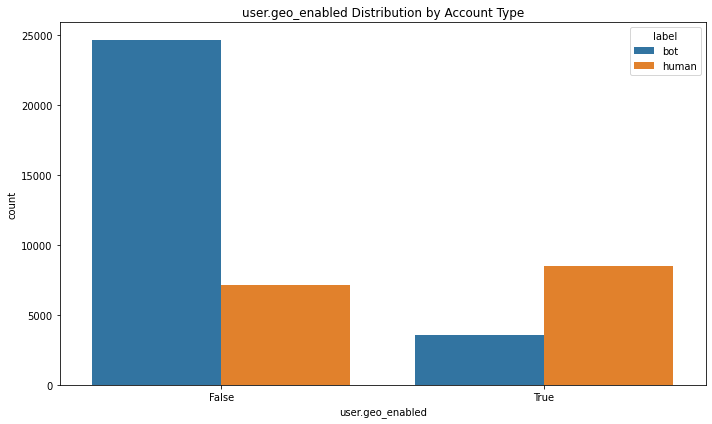


user.default_profile distribution by account type:
label  user.default_profile
bot    True                    0.772291
       False                   0.227709
human  False                   0.693754
       True                    0.306246
Name: user.default_profile, dtype: float64


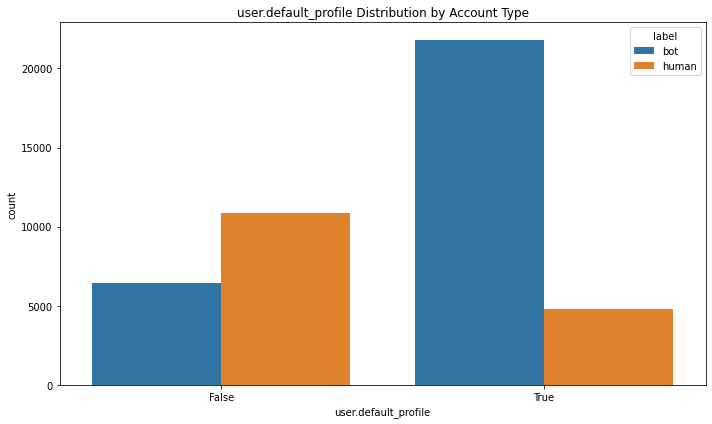


user.default_profile_image distribution by account type:
label  user.default_profile_image
bot    False                         0.987540
       True                          0.012460
human  False                         0.991944
       True                          0.008056
Name: user.default_profile_image, dtype: float64


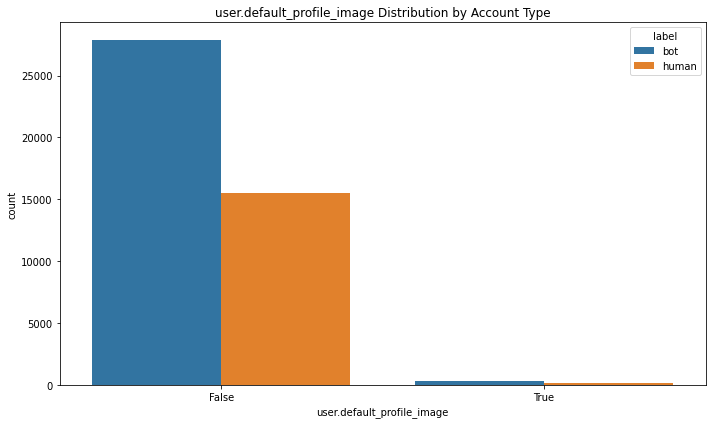


user.has_extended_profile distribution by account type:
label  user.has_extended_profile
bot    False                        0.902411
       True                         0.097589
human  False                        0.652132
       True                         0.347868
Name: user.has_extended_profile, dtype: float64


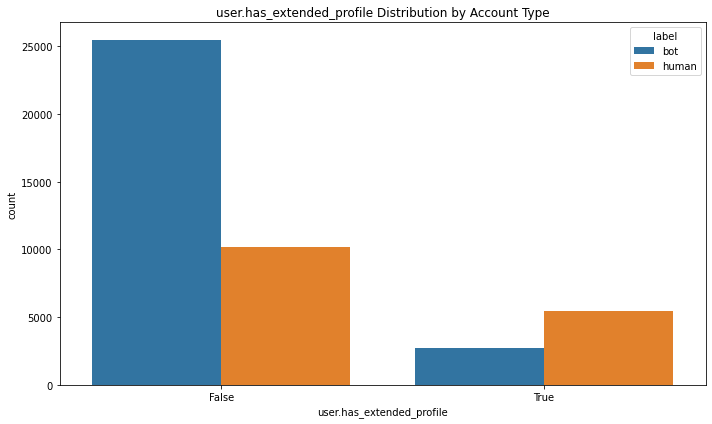


Date range of tweets:
Earliest: 2009-10-25 03:23:12+00:00
Latest: 2019-06-06 01:14:09+00:00

Date range of account creation:
Earliest: 2006-07-05 19:52:46+00:00
Latest: 2019-04-24 08:53:21+00:00

Account age statistics by account type:
         count         mean         std  min     25%     50%     75%     max
label                                                                       
bot    28251.0  1849.061308  840.677060  0.0  1330.0  1935.0  2425.0  4436.0
human  15641.0  2562.635637  965.027314  0.0  2076.0  2786.0  3248.0  4710.0


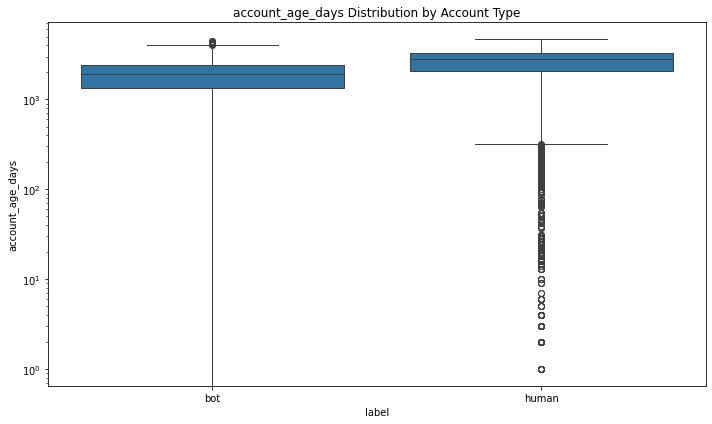


user.description length statistics by account type:
         count       mean        std  min   25%   50%    75%    max
label                                                              
bot    28251.0  51.574741  34.081527  0.0  38.0  53.0   62.0  326.0
human  15641.0  73.279522  54.322540  0.0  23.0  68.0  124.0  176.0


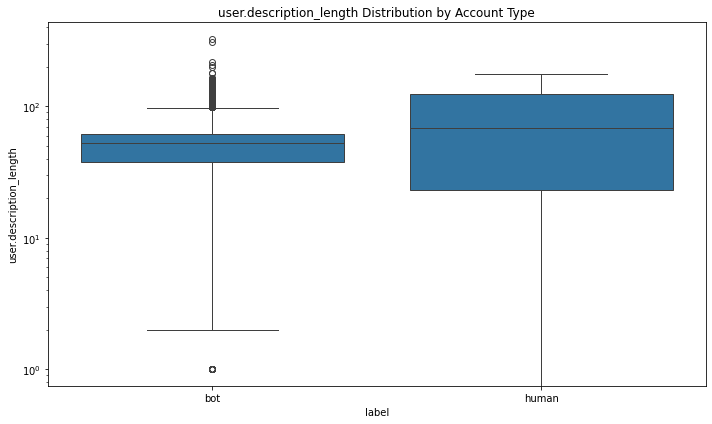


user.name length statistics by account type:
         count       mean       std  min   25%   50%   75%   max
label                                                           
bot    28251.0  12.597820  3.544870  0.0  11.0  13.0  15.0  50.0
human  15641.0  12.079854  4.757477  0.0   9.0  12.0  15.0  50.0


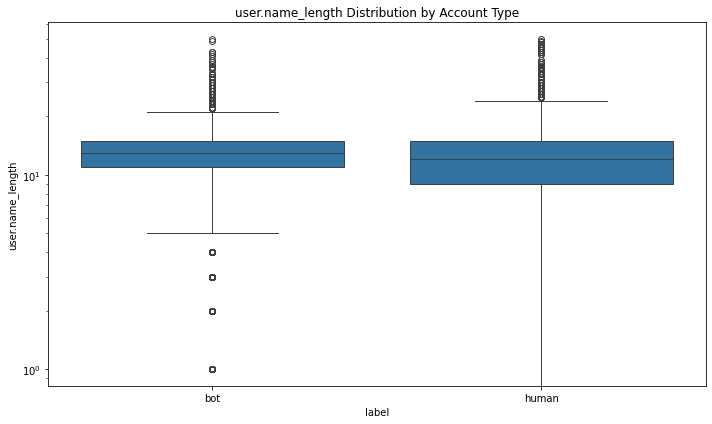


user.screen_name length statistics by account type:
         count       mean       std  min  25%   50%   75%   max
label                                                          
bot    28251.0  10.814272  2.676628  2.0  9.0  11.0  13.0  15.0
human  15641.0  11.122435  2.628057  2.0  9.0  11.0  13.0  15.0


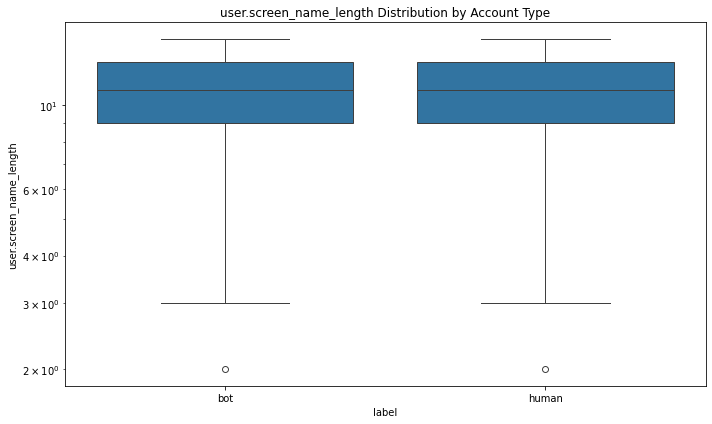

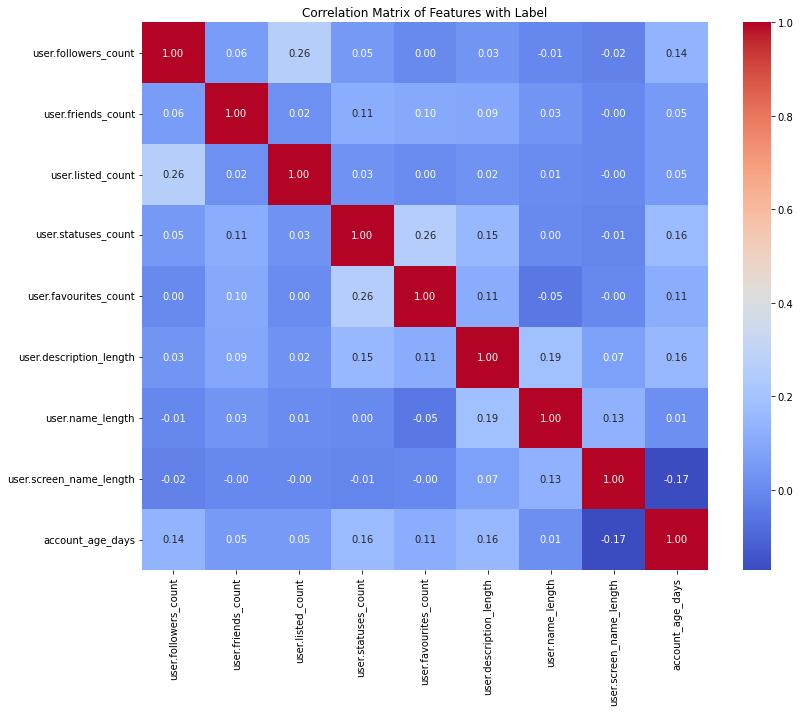

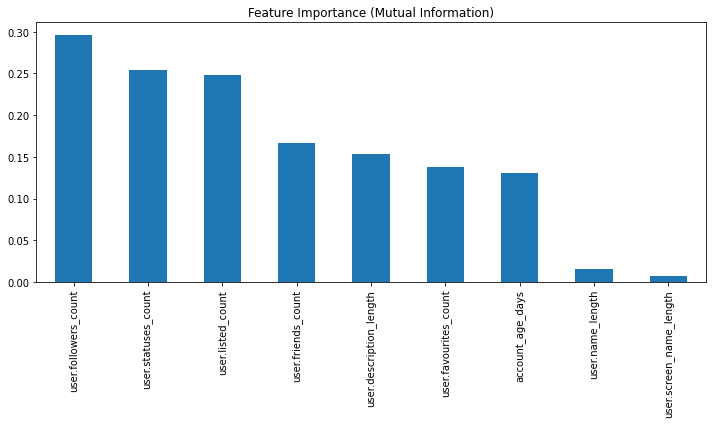


Top 5 most important features:
user.followers_count       0.296374
user.statuses_count        0.254154
user.listed_count          0.248508
user.friends_count         0.166247
user.description_length    0.152883
Name: MI Scores, dtype: float64

EDA completed. All plots have been displayed interactively.


In [ ]:
do_EDA2(df)

## Bibliography

https://www.kaggle.com/code/leeyj0511/kor-binary-classification-eda-feature-select#Feature-Selection-and-Random-Forest-Classification